# [Give me some credit competition](https://www.kaggle.com/c/GiveMeSomeCredit/overview) - Feature Engineering & Prediction
---

Link to the EDA & Data Cleaning part : [EDA-Cleaning](https://www.kaggle.com/jamesngoa/credit-scoring-challenge-eda-data-cleaning)
### Competition Intro : 
*Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit.* 

*Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.*

*The goal of this competition is to build a model that borrowers can use to help make the best financial decisions.*

*Historical data are provided on 250,000 borrowers.*

---
### Data Dictionary

`SeriousDlqin2yrs` : Person experienced 90 days past due delinquency or worse.

`RevolvingUtilizationOfUnsecuredLines` : Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits.

`age` : Age of borrower in years.

`NumberOfTime30-59DaysPastDueNotWorse` : Number of times borrower has been 30-59 days past due but no worse in the last 2 years.

`DebtRatio` : Monthly debt payments, alimony,living costs divided by monthy gross income.

`MonthlyIncome` : Monthly income.

`NumberOfOpenCreditLinesAndLoans` : Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards).

`NumberOfTimes90DaysLate` : Number of times borrower has been 90 days or more past due.

`NumberRealEstateLoansOrLines` : Number of mortgage and real estate loans including home equity lines of credit.

`NumberOfTime60-89DaysPastDueNotWorse` : Number of times borrower has been 60-89 days past due but no worse in the last 2 years.

`NumberOfDependents` : Number of dependents in family excluding themselves (spouse, children etc.).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [2]:
def plot_formatting():
    '''
    Set up the default plotting settings.
    '''
    
    plt.rc(
        'figure',
        figsize=(12,6),
        titleweight='bold',
        titlesize=25
    )
    plt.rc(
        'axes',
        labelweight='ultralight',
        titleweight='ultralight',
        titlelocation='left',
        titlecolor='k',
        titley=1.03,
        titlesize=16,
        grid=True
    )
    plt.rc(
        'axes.spines',
        right=False,
        left=False,
        top=False   
    )
    plt.rc(
        'grid',
        color='k',
        linestyle=(0,15,2,0),
        alpha=0.5
    )
    plt.rc('axes.grid', axis='y')
    plt.rc('ytick.major', width=0)
    plt.rc('font', family='monospace')
    
plot_formatting() # Setting our default settings

In [3]:
train = pd.read_csv('../input/cleaned-datasets-give-me-some-credit/Cleaned_train.csv')
test = pd.read_csv('../input/cleaned-datasets-give-me-some-credit/Cleaned_test.csv')

In [4]:
y = train['SeriousDlqin2yrs']
train = train.drop('SeriousDlqin2yrs', axis=1)

In [5]:
train.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Debt
0,0.766127,45,2,0.802982,9120,13,0,6,0,2,7323.197016
1,0.957151,40,0,0.121876,2600,4,0,0,0,1,316.878123
2,0.658180,38,1,0.085113,3042,2,1,0,0,0,258.914887
3,0.233810,30,0,0.036050,3300,5,0,0,0,0,118.963951
4,0.907239,49,1,0.024926,63588,7,0,1,0,0,1584.975094


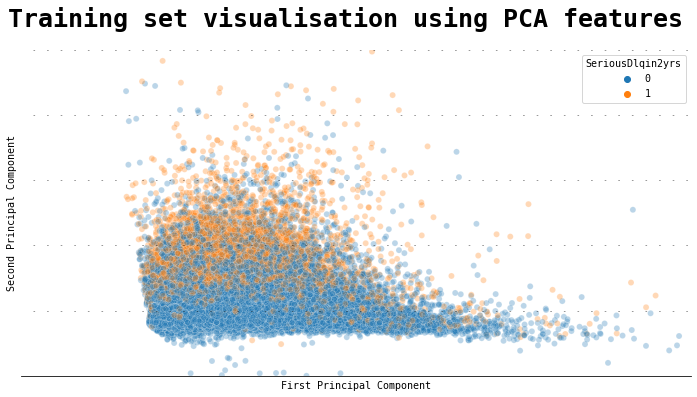

In [6]:
X_stand = StandardScaler().fit_transform(train)
pca = PCA(n_components=2).fit(X_stand)
X_pca = pca.transform(X_stand)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, alpha=0.3)
plt.tick_params(bottom=False, labelbottom=False, labelleft=False)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.xlim(-6, 13)
plt.ylim(-5, 20)
plt.suptitle('Training set visualisation using PCA features');

In [8]:
def score_dataset(X, y, fold_scores=False, model = DecisionTreeClassifier(max_depth=7, min_samples_leaf=25,
                                                       min_samples_split = 4, random_state=0)):
    
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    oof = np.zeros(len(X))

    for fold_, (train_idx, val_idx) in enumerate(folds.split(X.values, y.values)):
        
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        clf = model.fit(X_train, y_train)
        
        oof[val_idx] = clf.predict_proba(X_val)[:, 1]
        
        if fold_scores:
            print('Fold score: ', roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1]))

    print("CV score: {:.8f}".format(roc_auc_score(y, oof)))
    return

<AxesSubplot:>

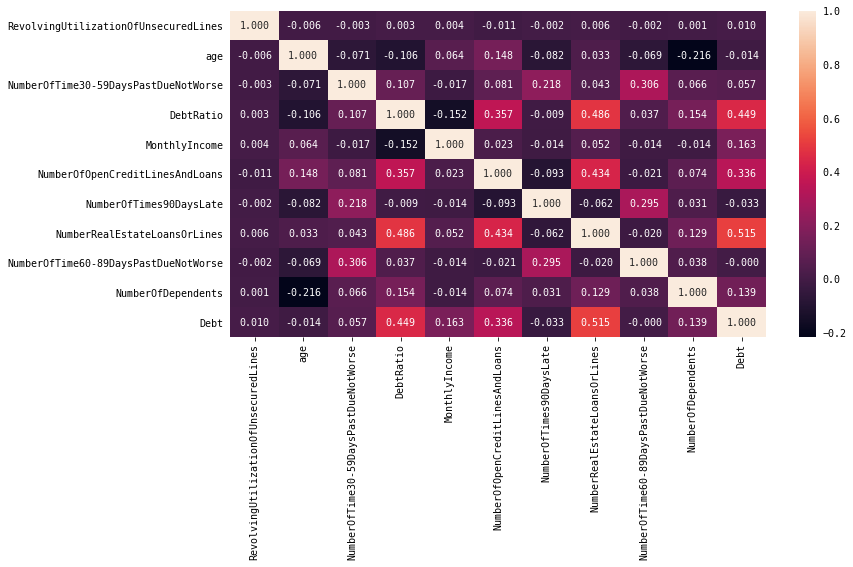

In [9]:
sns.heatmap(train.corr(), annot=True, fmt='.3f')

## Feature Engineering

### Baseline Score

In [13]:
score_dataset(train, y)

CV score: 0.85134014


### Assessment of the relevance of new features

In [14]:
X = train.copy()

X['Weighted_Sum_PastDue'] = 2 * X['NumberOfTime30-59DaysPastDueNotWorse'] + 3 * X['NumberOfTime60-89DaysPastDueNotWorse'] + 6 * X['NumberOfTimes90DaysLate']

X['90days_out_of_TotalPastDue'] = X['NumberOfTimes90DaysLate'] / (X['Weighted_Sum_PastDue'])
X.loc[X['Weighted_Sum_PastDue']==0, '90days_out_of_TotalPastDue'] = 0

score_dataset(X, y)

CV score: 0.85314856


In [15]:
X = train.copy()

X['RevolvingUtilization_per_age'] = X['RevolvingUtilizationOfUnsecuredLines'] / X['age']

score_dataset(X, y)

CV score: 0.85290605


In [16]:
X = train.copy()

X['Disposable_Income_per_person'] = (X['MonthlyIncome'] - X['Debt']) / (X['NumberOfDependents'] + 1)
X.loc[X['NumberOfDependents']==0, 'Disposable_Income_per_person'] = 0

X.drop('MonthlyIncome', axis=1, inplace=True)
score_dataset(X, y)

CV score: 0.85197436


In [17]:
X = train.copy()

X['Debt_per_Real_Estate_Loan'] = X['Debt'] / X['NumberRealEstateLoansOrLines']
X.loc[X['NumberRealEstateLoansOrLines']==0, 'Debt_per_Real_Estate_Loan'] = 0

X.drop('Debt', axis=1, inplace=True)
score_dataset(X, y)

CV score: 0.85157713


In [18]:
X = train.copy()

X['RemainingLines_per_person'] = (X['NumberOfOpenCreditLinesAndLoans'] - X['NumberRealEstateLoansOrLines']) / (X['NumberOfDependents'] + 1)

score_dataset(X, y)

CV score: 0.85150781


In [19]:
X = train.copy()

X['Ratio_age_per_number_of_dependents'] = X['age'] / (X['NumberOfDependents'])
X.loc[X['NumberOfDependents']==0, 'Ratio_age_per_number_of_dependents'] = 0

score_dataset(X, y)

CV score: 0.85149191


In [20]:
X = train.copy()

X['Never3089'] = ((X['NumberOfTime30-59DaysPastDueNotWorse'] * X['NumberOfTime60-89DaysPastDueNotWorse']) > 0).astype('int64')

score_dataset(X, y)

CV score: 0.85145439


In [21]:
X = train.copy()

X['RelvovingLines'] = X['NumberOfOpenCreditLinesAndLoans'] - X['NumberRealEstateLoansOrLines']

X['HasRevolvingLines'] = (X['RelvovingLines']>0).astype('int64')

score_dataset(X, y)

CV score: 0.85144799


In [22]:
X = train.copy()

X['Minor_PastDue_per_Line'] = X['NumberOfTime30-59DaysPastDueNotWorse'] / X['NumberOfOpenCreditLinesAndLoans']
X.loc[X['NumberOfOpenCreditLinesAndLoans']==0, 'Minor_PastDue_per_Line'] = 0

score_dataset(X, y)

CV score: 0.85151952


### Score when new features are added

In [23]:
X = train.copy()

X['Weighted_Sum_PastDue'] = 2 * X['NumberOfTime30-59DaysPastDueNotWorse'] + 3 * X['NumberOfTime60-89DaysPastDueNotWorse'] + 6 * X['NumberOfTimes90DaysLate']

X['90days_out_of_TotalPastDue'] = X['NumberOfTimes90DaysLate'] / (X['Weighted_Sum_PastDue'])
X.loc[X['Weighted_Sum_PastDue']==0, '90days_out_of_TotalPastDue'] = 0

X['RemainingLines'] = X['NumberOfOpenCreditLinesAndLoans'] - X['NumberRealEstateLoansOrLines']

X['Loans_vs_Other_Lines'] = X['RemainingLines'] / (1 + X['NumberRealEstateLoansOrLines'])

X['Debt_per_Real_Estate_Loan'] = X['Debt'] / X['NumberRealEstateLoansOrLines']
X.loc[X['NumberRealEstateLoansOrLines']==0, 'Debt_per_Real_Estate_Loan'] = 0

X['Disposable_Income_per_person'] = (X['MonthlyIncome'] - X['Debt']) / (X['NumberOfDependents'] + 1)
X.loc[X['NumberOfDependents']==0, 'Disposable_Income_per_person'] = 0

X['RemainingLines_per_person'] = X['RemainingLines'] / (X['NumberOfDependents'] + 1)

X['NumberRE_X_DebtRatio_X_age'] = X['NumberRealEstateLoansOrLines'] * X['DebtRatio'] / X['age']

X['RevolvingUtilization_per_age'] = X['RevolvingUtilizationOfUnsecuredLines'] / X['age']

X.drop(['MonthlyIncome', 'NumberRealEstateLoansOrLines'], axis=1, inplace=True)
score_dataset(X, y)

CV score: 0.85549797


### Additional features to improve final score: PCA features

In [24]:
def PCA_features():
    
    df = pd.concat([train, test.drop(['SeriousDlqin2yrs'], axis=1)], axis=0)

    X_stand = StandardScaler().fit_transform(df)
    pca = PCA().fit(X_stand)
    X_pca = pca.transform(X_stand)

    Components_names = ['PC{}'.format(i) for i in range(1, pca.n_components_ + 1)]
    PC_df_train = pd.DataFrame(X_pca, columns = Components_names)[:len(train)]
    PC_df_test = pd.DataFrame(X_pca, columns = Components_names)[len(train):len(train) + len(test)].reset_index()
    
    return PC_df_train, PC_df_test

In [25]:
def feature_eng(df):
    
    df['Weighted_Sum_PastDue'] = 2 * df['NumberOfTime30-59DaysPastDueNotWorse'] + 3 * df['NumberOfTime60-89DaysPastDueNotWorse'] + 6 * df['NumberOfTimes90DaysLate']

    df['90days_out_of_TotalPastDue'] = df['NumberOfTimes90DaysLate'] / (df['Weighted_Sum_PastDue'])
    df.loc[df['Weighted_Sum_PastDue']==0, '90days_out_of_TotalPastDue'] = 0

    df['RemainingLines'] = df['NumberOfOpenCreditLinesAndLoans'] - df['NumberRealEstateLoansOrLines']

    df['Loans_vs_Other_Lines'] = df['RemainingLines'] / (1 + df['NumberRealEstateLoansOrLines'])

    df['Debt_per_Real_Estate_Loan'] = df['Debt'] / df['NumberRealEstateLoansOrLines']
    df.loc[df['NumberRealEstateLoansOrLines']==0, 'Debt_per_Real_Estate_Loan'] = 0

    df['Disposable_Income_per_person'] = (df['MonthlyIncome'] - df['Debt']) / (df['NumberOfDependents'] + 1)
    df.loc[df['NumberOfDependents']==0, 'Disposable_Income_per_person'] = 0

    df['RemainingLines_per_person'] = df['RemainingLines'] / (df['NumberOfDependents'] + 1)

    df['NumberRE_X_DebtRatio_X_age'] = df['NumberRealEstateLoansOrLines'] * df['DebtRatio'] / df['age']

    df['RevolvingUtilization_per_age'] = df['RevolvingUtilizationOfUnsecuredLines'] / df['age']

    df.drop(['MonthlyIncome', 'NumberRealEstateLoansOrLines'], axis=1, inplace=True)
    
    return df

### Transformation of raw train and test datasets

In [26]:
PCA_features = PCA_features()
train = train.join(PCA_features[0][['PC1','PC5','PC9']])
test = test.join(PCA_features[1][['PC1','PC5','PC9']])
train = feature_eng(train)
test = feature_eng(test)

##### Score of this new train dataset with our simply tuned Decision Tree Classifier

In [27]:
score_dataset(train, y)

CV score: 0.85634844


Baseline score was 85.13404

# Modeling

In [28]:
def score_model(X, y, model, print_fold_scores=False):
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    oof = np.zeros(len(X))
    predictions = np.zeros(len(test))

    for fold_, (train_idx, val_idx) in enumerate(folds.split(X.values, y.values)):
        print('Fold {}'.format(fold_))
        
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        clf = model.fit(X_train, y_train)
        
        oof[val_idx] = clf.predict_proba(X_val)[:, 1]
        
        if print_fold_scores:
            print('Fold train score: ', roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
            print('Fold val score: ', roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1]))
            
            
        predictions += clf.predict_proba(test.drop('SeriousDlqin2yrs', axis=1))[:, 1] / folds.n_splits
        
    print("CV score: {:.8f}".format(roc_auc_score(y, oof)))
    
    return predictions

In [1]:
# Found after a Bayesian Optimization process (code below)

GBM_params = {'learning_rate': 0.0018069834369607075,
             'max_depth': 8,
             'max_features': 4,
             'min_samples_leaf': 47,
             'min_samples_split': 389,
             'subsample': 0.8573598985000007,
             'n_iter_no_change': 300,
             'n_estimators': 5000,
             'verbose': 1,
             'random_state': 144}

In [31]:
predictions = score_model(train, y, GradientBoostingClassifier(**GBM_params), True)

Fold 0
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4925           0.0006           11.65m
         2           0.4897           0.0006           13.83m
         3           0.4869           0.0005           13.21m
         4           0.4889           0.0005           13.79m
         5           0.4861           0.0004           14.50m
         6           0.4862           0.0007           14.03m
         7           0.4867           0.0006           14.02m
         8           0.4863           0.0006           13.66m
         9           0.4831           0.0007           13.37m
        10           0.4874           0.0006           13.16m
        20           0.4792           0.0006           13.16m
        30           0.4746           0.0005           12.91m
        40           0.4699           0.0004           12.92m
        50           0.4693           0.0004           12.81m
        60           0.4599           0.0004           12.67m


### Bayesian Optimization code to find GBDT hyperparameters

In [10]:
# bayes_cv_tuner = BayesSearchCV(estimator = GradientBoostingClassifier(n_iter_no_change = 300,
#                                                                       n_estimators = 5000,
#                                                                       verbose=1,
#                                                                       random_state=144),
                               
#                                search_spaces = {'learning_rate': (0.001, 0.04),
#                                                 'max_depth': (1, 8),
#                                                 'subsample': (0.01, 1.0, 'uniform'),
#                                                 'min_samples_split': (10, 500, 'log-uniform'),
#                                                 'min_samples_leaf': (5, 50, 'log-uniform'),
#                                                 'max_features': (2, 15, 'uniform')},
                               
#                                scoring = 'roc_auc',
#                                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
#                                n_jobs = -1,
#                                n_iter = 20,
#                                n_points=3,
#                                verbose = 500,
#                                refit = True,
#                                random_state = 786)

# result = bayes_cv_tuner.fit(train.values, y.values)

In [32]:
sample_submission = pd.read_csv('../input/GiveMeSomeCredit/sampleEntry.csv')
sample_submission['Probability'] = predictions
sample_submission.to_csv('sample_sub6.csv', index=False)

In [104]:
import warnings

try:
    from collections.abc import Sized
except ImportError:
    from collections import Sized

import numpy as np
from scipy.stats import rankdata

from sklearn.model_selection._search import BaseSearchCV
from sklearn.utils import check_random_state

from sklearn.utils.validation import check_is_fitted
try:
    from sklearn.metrics import check_scoring
except ImportError:
    from sklearn.metrics.scorer import check_scoring

from skopt import Optimizer
from skopt.utils import point_asdict, dimensions_aslist, eval_callbacks
from skopt.space import check_dimension
from skopt.callbacks import check_callback


class BayesSearchCV(BaseSearchCV):

    def __init__(self, estimator, search_spaces, optimizer_kwargs=None,
                 n_iter=50, scoring=None, fit_params=None, n_jobs=1,
                 n_points=1, iid='deprecated', refit=True, cv=None, verbose=0,
                 pre_dispatch='2*n_jobs', random_state=None,
                 error_score='raise', return_train_score=False):

        self.search_spaces = search_spaces
        self.n_iter = n_iter
        self.n_points = n_points
        self.random_state = random_state
        self.optimizer_kwargs = optimizer_kwargs
        self._check_search_space(self.search_spaces)
        # Temporary fix for compatibility with sklearn 0.20 and 0.21
        # See scikit-optimize#762
        # To be consistent with sklearn 0.21+, fit_params should be deprecated
        # in the constructor and be passed in ``fit``.
        self.fit_params = fit_params

        if iid != "deprecated":
            warnings.warn("The `iid` parameter has been deprecated "
                          "and will be ignored.")
        self.iid = iid  # For sklearn repr pprint

        super(BayesSearchCV, self).__init__(
             estimator=estimator, scoring=scoring,
             n_jobs=n_jobs, refit=refit, cv=cv, verbose=verbose,
             pre_dispatch=pre_dispatch, error_score=error_score,
             return_train_score=return_train_score)

    def _check_search_space(self, search_space):
        """Checks whether the search space argument is correct"""

        if len(search_space) == 0:
            raise ValueError(
                "The search_spaces parameter should contain at least one"
                "non-empty search space, got %s" % search_space
            )

        # check if space is a single dict, convert to list if so
        if isinstance(search_space, dict):
            search_space = [search_space]

        # check if the structure of the space is proper
        if isinstance(search_space, list):
            # convert to just a list of dicts
            dicts_only = []

            # 1. check the case when a tuple of space, n_iter is provided
            for elem in search_space:
                if isinstance(elem, tuple):
                    if len(elem) != 2:
                        raise ValueError(
                            "All tuples in list of search spaces should have"
                            "length 2, and contain (dict, int), got %s" % elem
                        )
                    subspace, n_iter = elem

                    if (not isinstance(n_iter, int)) or n_iter < 0:
                        raise ValueError(
                            "Number of iterations in search space should be"
                            "positive integer, got %s in tuple %s " %
                            (n_iter, elem)
                        )

                    # save subspaces here for further checking
                    dicts_only.append(subspace)
                elif isinstance(elem, dict):
                    dicts_only.append(elem)
                else:
                    raise TypeError(
                        "A search space should be provided as a dict or"
                        "tuple (dict, int), got %s" % elem)

            # 2. check all the dicts for correctness of contents
            for subspace in dicts_only:
                for k, v in subspace.items():
                    check_dimension(v)
        else:
            raise TypeError(
                "Search space should be provided as a dict or list of dict,"
                "got %s" % search_space)

    @property
    def optimizer_results_(self):
        check_is_fitted(self, '_optim_results')
        return self._optim_results

    def _make_optimizer(self, params_space):
        """Instantiate skopt Optimizer class.
        Parameters
        ----------
        params_space : dict
            Represents parameter search space. The keys are parameter
            names (strings) and values are skopt.space.Dimension instances,
            one of Real, Integer or Categorical.
        Returns
        -------
        optimizer: Instance of the `Optimizer` class used for for search
            in some parameter space.
        """

        kwargs = self.optimizer_kwargs_.copy()
        kwargs['dimensions'] = dimensions_aslist(params_space)
        optimizer = Optimizer(**kwargs)
        for i in range(len(optimizer.space.dimensions)):
            if optimizer.space.dimensions[i].name is not None:
                continue
            optimizer.space.dimensions[i].name = list(sorted(
                params_space.keys()))[i]

        return optimizer

    def _step(self, search_space, optimizer, evaluate_candidates, n_points=1):
        """Generate n_jobs parameters and evaluate them in parallel.
        """
        # get parameter values to evaluate
        params = optimizer.ask(n_points=n_points)

        # convert parameters to python native types
        params = [[np.array(v).item() for v in p] for p in params]

        # make lists into dictionaries
        params_dict = [point_asdict(search_space, p) for p in params]

        all_results = evaluate_candidates(params_dict)
        # Feed the point and objective value back into optimizer
        # Optimizer minimizes objective, hence provide negative score
        local_results = all_results["mean_test_score"][-len(params):]
        return optimizer.tell(params, [-score for score in local_results])

    @property
    def total_iterations(self):
        """
        Count total iterations that will be taken to explore
        all subspaces with `fit` method.
        Returns
        -------
        max_iter: int, total number of iterations to explore
        """
        total_iter = 0

        for elem in self.search_spaces:

            if isinstance(elem, tuple):
                space, n_iter = elem
            else:
                n_iter = self.n_iter

            total_iter += n_iter

        return total_iter

    def fit(self, X, y=None, *, groups=None, callback=None, **fit_params):
        """Run fit on the estimator with randomly drawn parameters.
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples] or [n_samples, n_output]
            Target relative to X for classification or regression (class
            labels should be integers or strings).
        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        callback: [callable, list of callables, optional]
            If callable then `callback(res)` is called after each parameter
            combination tested. If list of callables, then each callable in
            the list is called.
        """
        self._callbacks = check_callback(callback)

        if self.optimizer_kwargs is None:
            self.optimizer_kwargs_ = {}
        else:
            self.optimizer_kwargs_ = dict(self.optimizer_kwargs)

        super().fit(X=X, y=y, groups=groups, **fit_params)

        # BaseSearchCV never ranked train scores,
        # but apparently we used to ship this (back-compat)
        if self.return_train_score:
            self.cv_results_["rank_train_score"] = \
                rankdata(-np.array(self.cv_results_["mean_train_score"]),
                         method='min').astype(int)
        return self

    def _run_search(self, evaluate_candidates):
        # check if space is a single dict, convert to list if so
        search_spaces = self.search_spaces
        if isinstance(search_spaces, dict):
            search_spaces = [search_spaces]

        callbacks = self._callbacks

        random_state = check_random_state(self.random_state)
        self.optimizer_kwargs_['random_state'] = random_state

        # Instantiate optimizers for all the search spaces.
        optimizers = []
        for search_space in search_spaces:
            if isinstance(search_space, tuple):
                search_space = search_space[0]
            optimizers.append(self._make_optimizer(search_space))
        self.optimizers_ = optimizers  # will save the states of the optimizers

        self._optim_results = []

        n_points = self.n_points

        for search_space, optimizer in zip(search_spaces, optimizers):
            # if not provided with search subspace, n_iter is taken as
            # self.n_iter
            if isinstance(search_space, tuple):
                search_space, n_iter = search_space
            else:
                n_iter = self.n_iter

            # do the optimization for particular search space
            while n_iter > 0:
                # when n_iter < n_points points left for evaluation
                n_points_adjusted = min(n_iter, n_points)

                optim_result = self._step(
                    search_space, optimizer,
                    evaluate_candidates, n_points=n_points_adjusted
                )
                n_iter -= n_points

                if eval_callbacks(callbacks, optim_result):
                    break
            self._optim_results.append(optim_result)